##PALETTE EXTRACTION
In questo notebook è presente tutto il processo che mi ha portato allo sviluppo di una funzione di estrazione di palette di colori da una foto. Sono state effettuate delle prove di clusterizzazione su due Color Spaces (RGB e HSV) utilizzando l'algoritmo K-Means.
Il principale problema di questo approccio è stato quello di individuare in modo generale k (numero di cluster) che fosse il più piccolo possibile ma che rappresentasse degnamente il range di colori di una foto.
Ho provato a risolvere ciò facendo degli esperimenti sui channel separati H, S e V cercando di trovare un valore empirico di k dipendente dal numero di tonalità presenti.

In [1]:
# Install Google Drive Download to get file from Google Drive
!pip install googledrivedownloader

# Install OpenCV and Requirements
!pip uninstall imgaug -y
!pip install imgaug==0.2.5
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

Found existing installation: imgaug 0.2.9
Uninstalling imgaug-0.2.9:
  Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 562 kB 14.2 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.5-py3-none-any.whl size=561438 sha256=e358d461c2582888f091dc5b8429d968a0dba921df4a75d124ba26ddc158d391
  Stored in directory: /root/.cache/pip/wheels/60/dd/38/d1dc2cad2b6a66dc0249261004990bccb0f27985c74ba26e49
Successfully built imgaug
     |████████████████████████████████| 60.5 MB 1.1 MB/s 


In [2]:
!git clone https://github.com/felichan98/AISchools
import sys
sys.path.insert(0,'/content/AISchools')

Cloning into 'AISchools'...
remote: Enumerating objects: 19295, done.
remote: Counting objects: 100% (2511/2511), done.
remote: Compressing objects: 100% (2468/2468), done.
remote: Total 19295 (delta 45), reused 2503 (delta 40), pack-reused 16784
Receiving objects: 100% (19295/19295), 2.62 GiB | 16.21 MiB/s, done.
Resolving deltas: 100% (189/189), done.
Checking out files: 100% (2594/2594), done.


In [3]:
import cv2
print('OpenCV version: ' + cv2.__version__)

from matplotlib import pyplot as plt

import numpy as np

from google_drive_downloader import GoogleDriveDownloader as gdd

OpenCV version: 4.5.5


In [4]:
# IMMAGINI DI PROVA

gdd.download_file_from_google_drive(file_id='1BJzJRRBTCWsxBQtrwYPY9SNKOUr2pPEU',
                                    dest_path='./data/flower1.png',
                                    unzip=False)

im_path1 = '/content/AISchools/Pictures/venz.JPG'

In [5]:
gdd.download_file_from_google_drive(file_id='1H97B0oEA7cXP-QimSs6wlf7YD8DAdcrw',
                                    dest_path='./data/flower3.png',
                                    unzip=False)

im_path2 = './data/flower3.png'


In [6]:
gdd.download_file_from_google_drive(file_id='11tZ_QROC__IcsYVVaMt_s2vaH3faiAtG',
                                    dest_path='./data/flag.png',
                                    unzip=False)

im_path3 = './data/flag.png'

Una funzione di resize che mantiene il ratio dell'immagine.

In [7]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
        
    if width is None:

        r = height / float(h)
        dim = (int(w * r), height)

    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv2.resize(image, dim, interpolation = inter)
    return resized

Funzione per convertire un colore (array di 3 elementi) da un color space all'altro mantenendo la compatibilità con la rappresentazione dei color spaces di openCV. In OpenCV il canale H va da [0,180].

In [8]:
# in conversion usare direttamente il flag di cv2.COLOR_-2-

def color_converter(color, conversion):
  
  color = np.uint8([[color]])  
  color = cv2.cvtColor(color, conversion)
  color = color[0][0]

  return color

Lettura delle immagini di test

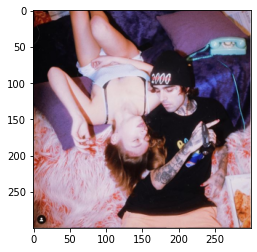

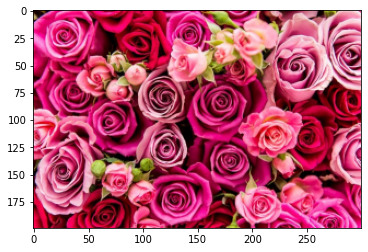

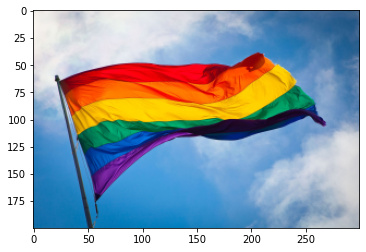

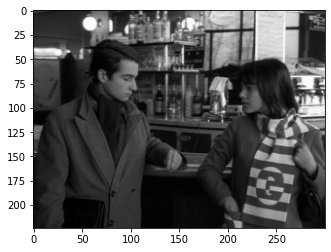

In [9]:
#IMMAGINE 1

img_input1 = cv2.imread(im_path1, cv2.IMREAD_COLOR)
img_input1 = cv2.cvtColor(img_input1, cv2.COLOR_BGR2RGB)

img_input1 = image_resize(img_input1, width= 300)

#IMMAGINE 2

img_input2 = cv2.imread(im_path2, cv2.IMREAD_COLOR)
img_input2 = cv2.cvtColor(img_input2, cv2.COLOR_BGR2RGB)

img_input2 = image_resize(img_input2, width= 300)

#IMMAGINE 3

img_input3 = cv2.imread(im_path3, cv2.IMREAD_COLOR)
img_input3 = cv2.cvtColor(img_input3, cv2.COLOR_BGR2RGB)

img_input3 = image_resize(img_input3, width= 300)

#IMMAGINE 4 (B&W)

im_path4 = '/content/AISchools/Pictures/bw.jpg'

img_input4 = cv2.imread(im_path4, cv2.IMREAD_COLOR)
img_input4 = cv2.cvtColor(img_input4, cv2.COLOR_BGR2RGB)

img_input4 = image_resize(img_input4, width= 300)

#SHOW

plt.imshow(img_input1)
plt.show()
plt.imshow(img_input2)
plt.show()
plt.imshow(img_input3)
plt.show()

plt.imshow(img_input4)
plt.show()


##K-MEANS
Funzione che esegue kmeans e genera una nuova immagine quantizzata

In [10]:
def k_means(img, k):

  shape = img.shape

  if(img.ndim == 3):
    img = np.float32(img).reshape((-1, 3))

  #Per ottimizzare il processo rispetto ai valori da documentazione scelgo un criterio con Halt=15, epsilon=0.01 e 5 tentativi

  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 15, 0.01)

  ret, label, center = cv2.kmeans(img, k, None, criteria, 5, cv2.KMEANS_RANDOM_CENTERS)
  center = np.uint8(center)
  result = center[label.flatten()]
  #print(label.ravel())
  result = result.reshape(shape)
  return result

Conversione delle immagini da RGB a HSV

In [11]:
#IMMAGINE TEST 1

img_rgb1 = img_input1
img_hsv1 = cv2.cvtColor(img_input1, cv2.COLOR_RGB2HSV)

#IMMAGINE TEST 2

img_rgb2 = img_input2
img_hsv2 = cv2.cvtColor(img_input2, cv2.COLOR_RGB2HSV)

#IMMAGINE TEST 3

img_rgb3 = img_input3
img_hsv3 = cv2.cvtColor(img_input3, cv2.COLOR_RGB2HSV)

#IMMAGINE TEST 4

img_rgb4 = img_input4
img_hsv4 = cv2.cvtColor(img_input4, cv2.COLOR_RGB2HSV)


Effettuo delle prove utilizzando il clustering sia nello spazio RGB che nello spazio HSV per capire se le distanze nei vari color spaces si mantengano invariate.

In [12]:
num_colors_1 = 4

img_rgb1_out = k_means(img_rgb1, num_colors_1)

img_hsv1_out = k_means(img_hsv1, num_colors_1)

#Riconverto in RGB per visualizzare

img_hsv1_out = cv2.cvtColor(img_hsv1_out, cv2.COLOR_HSV2RGB)

In [13]:
num_colors_2 = 3

img_rgb2_out = k_means(img_rgb2, num_colors_2)

img_hsv2_out = k_means(img_hsv2, num_colors_2)

#Riconverto in RGB per visualizzare

img_hsv2_out = cv2.cvtColor(img_hsv2_out, cv2.COLOR_HSV2RGB)

In [14]:
num_colors_3 = 7

img_rgb3_out = k_means(img_rgb3, num_colors_3)

img_hsv3_out = k_means(img_hsv3, num_colors_3)

#Riconverto in RGB per visualizzare

img_hsv3_out = cv2.cvtColor(img_hsv3_out, cv2.COLOR_HSV2RGB)

VISUALIZZAZIONE

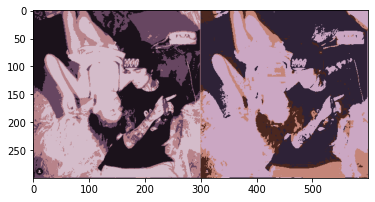

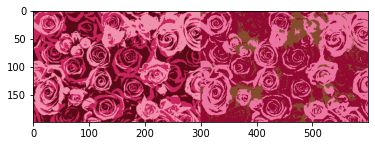

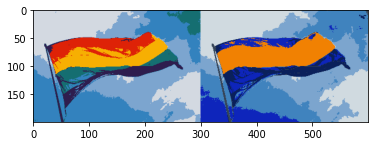

In [15]:
slide1 = cv2.hconcat([img_rgb1_out, img_hsv1_out])
plt.imshow(slide1)
plt.show()

slide2 = cv2.hconcat([img_rgb2_out, img_hsv2_out])
plt.imshow(slide2)
plt.show()

slide3 = cv2.hconcat([img_rgb3_out, img_hsv3_out])
plt.imshow(slide3)
plt.show()

### RGB |||||||||| HSV ###

Notiamo che c'è una evidente differenza tra l'eseguire la clusterizzazione dei colori nello spazio RGB rispetto allo spazio HSV. Ad esempio, in HSV, nella seconda immagine la suddivisione è riuscita a riconoscere meglio la distinzione di tonalità tra rosa e verde, mentre nell'ultima ha unito rosso e giallo in arancione. 

Durante la creazione di una pixel art è fondamentale individuare i colori ben distinti tra loro, e in base ad essi selezionare un numero di colori in palette proporzionale. Ad esempio, una foto contenente solo rosso e verde avrà una palette molto minore di una foto contenente tutti i colori dell'arcobaleno.
Siccome la quantità di colori indipendenti all'interno di una foto in input è ignoto, ho necessità di eseguire una clusterizzazione con k che si adatti al numero di tonalità presenti. Ad esempio, nella prima foto un k=4 è sufficiente a descrivere in modo accettabile la foto, ma ciò non è vero per la terza immagine, che presenta un range di colori molto più ampio. 

Il trade-off è trovare il minor k possibile che descriva bene il range cromatico della foto

Se usassimo k=4 per la bandiera il risultato sarebbe quello mostrato a seguito, che è alquanto deludente.

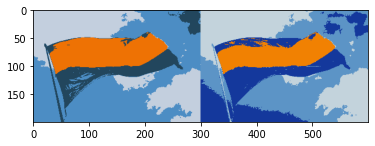

In [16]:
num_colors = 4

img_rgb3_out = k_means(img_rgb3, num_colors)

img_hsv3_out= k_means(img_hsv3, num_colors)

#Riconverto in RGB per visualizzare

img_hsv3_out = cv2.cvtColor(img_hsv3_out, cv2.COLOR_HSV2RGB)

#SHOW

slide3 = cv2.hconcat([img_rgb3_out, img_hsv3_out])
plt.imshow(slide3)
plt.show()

IDEA: Per aiutarmi nella scelta di k posso plottare l'istogramma di HUE e in base alle tonalità presenti regolarmi poi di conseguenza

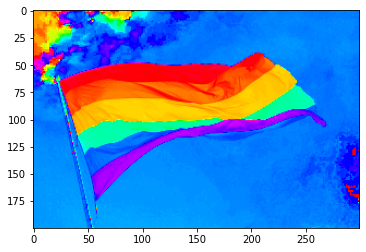

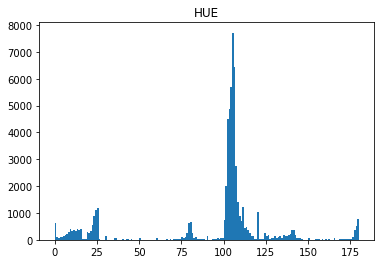

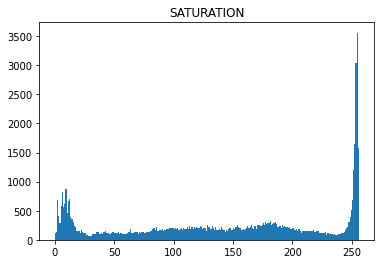

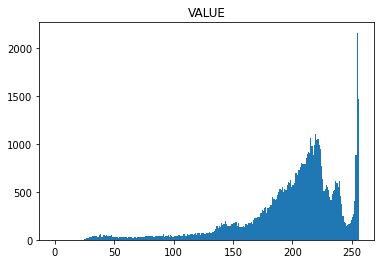

In [17]:
(H, S, V) = cv2.split(img_hsv3)

S_=np.full(S.shape, 255, dtype= 'uint8')
V_=np.full(V.shape, 255, dtype= 'uint8')

img_temp = cv2.merge([H,S_,V_])
img_temp = cv2.cvtColor(img_temp, cv2.COLOR_HSV2RGB)
plt.imshow(img_temp)
plt.show()

plt.title("HUE", fontdict=None, loc='center', pad=None)
plt.hist(H.ravel(),180,[0,180]);
plt.show()

plt.title("SATURATION", fontdict=None, loc='center', pad=None)
plt.hist(S.ravel(),256,[0,256]);
plt.show()

plt.title("VALUE", fontdict=None, loc='center', pad=None)
plt.hist(V.ravel(),256,[0,256]);
plt.show()

L'immagine della bandiera presenta 6 tonalità diverse (rosso arancione giallo verde viola e blu), e infatti nell'istogramma HUE ci sono 6 picchi, con a circa 105 un valore molto più elevato che sta a rappresentare la presenza maggiore di blu.

Situazione diversa è per le due foto di fiori che hanno un range di colori molto più compatto

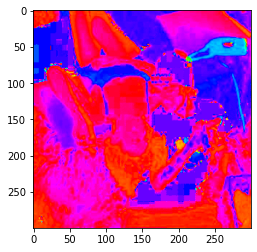

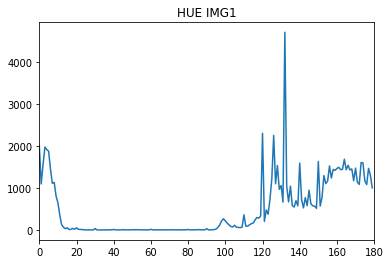

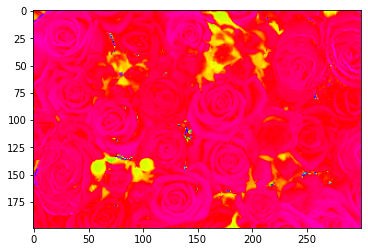

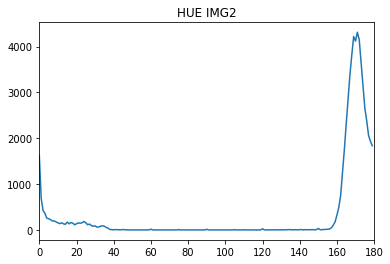

In [18]:
(H, S, V) = cv2.split(img_hsv1)

S_=np.full(S.shape, 255, dtype= 'uint8')
V_=np.full(V.shape, 255, dtype= 'uint8')

img_temp = cv2.merge([H,S_,V_])
img_temp = cv2.cvtColor(img_temp, cv2.COLOR_HSV2RGB)
plt.imshow(img_temp)
plt.show()

plt.title("HUE IMG1", fontdict=None, loc='center', pad=None)
hist1 = cv2.calcHist([H],[0],None,[180],[0,180])
plt.plot(hist1)
plt.xlim([0,180])
plt.show()

(H, S, V) = cv2.split(img_hsv2)

S_=np.full(S.shape, 255, dtype= 'uint8')
V_=np.full(V.shape, 255, dtype= 'uint8')

img_temp = cv2.merge([H,S_,V_])
img_temp = cv2.cvtColor(img_temp, cv2.COLOR_HSV2RGB)
plt.imshow(img_temp)
plt.show()


plt.title("HUE IMG2", fontdict=None, loc='center', pad=None)
hist2 = cv2.calcHist([H],[0],None,[180],[0,180])
plt.plot(hist2)
plt.xlim([0,180])
plt.show()


PASSO 1: Per scegliere il numero k per il kmeans conto quanti picchi ha l'istogramma delle tonalità. Come decido che un picco dell'istogramma sia significativo?

Definisco una scansione di colori in base alla tonalità e stabilisco che se nell'istogramma in quel range un bin supera lo 0.0025% del totale allora quella tonalità va considerata nel clustering. [La scelta del valore è empirica]

##TONALITA' COLORI

    Orange 0-15
    Yellow 15- 30
    Lime 30-45
    Green 45-60
    Mint Green 60-75
    Acquamarine 75-90
    Blue 90- 105
    Indigo 105-120
    Violet 120-135
    Purple 135-150
    Pink 150- 165
    Red 165-180



I colori li ho scelti in base a come li scelgo quando disegno

In [19]:
#DICTIONARY TONALITA' 

COLOR_HUES =	{
  "Orange": [0,15],
  "Yellow": [15,30],
  "Lime": [30,45],
  "Green": [45,60],
  "Mint Green": [60,75],
  "Acquamarine": [75,90],
  "Blue": [90,105],
  "Indigo": [105,120],
  "Violet": [120,135],
  "Purple": [135,150],
  "Pink": [150,165],
  "Red": [165,180]
}

Ho poi discretizzato anche i valori di saturazione e brightness.

In [20]:
# DICTIONARY SCHEMA SATURAZIONE
# Scelgo 5 livelli di saturazione

In [21]:
COLOR_SAT =	{
  "1": [0,102],  
  #"2": [51,102],
  "3": [102,153],
  #"4": [153,204],
  "5": [153,255],
}

In [22]:
# DICTIONARY SCHEMA BRIGHTNESS

COLOR_VAL =	{
  "1": [0,102],  
  "2": [51,102],
  "3": [102,153],
  "4": [153,255],
  "5": [204,255],

}

Funzioni che attraverso il calcolo dell'istogramma stabiliscono se una tonalità/saturazione/brightness sono presenti nella foto.

In [23]:
def hue_present(img, hue):
  total = img.shape[0] * img.shape[1]
  (H, S, V) = cv2.split(img)
  hist = cv2.calcHist([H],[0],None,[180],[0,180])

  if((hist[hue[0]:hue[1]].max() / total) > 0.0025):
    return True
  else:
    return False

def sat_present(img, sat):
  total = img.shape[0] * img.shape[1]
  (H, S, V) = cv2.split(img)
  hist = cv2.calcHist([S],[0],None,[256],[0,255])

  if((hist[sat[0]:sat[1]].max() / total) > 0.008):
    return True
  else:
    return False

def val_present(img, val):
  total = img.shape[0] * img.shape[1]
  (H, S, V) = cv2.split(img)
  hist = cv2.calcHist([V],[0],None,[256],[0,255])

  if((hist[val[0]:val[1]].max() / total) > 0.008):
    return True
  else:
    return False


Vari contatori che incrementano k in base alle fasce scelte in precedenza.

In [24]:
def hue_counter(img):
  k = 0

  for key in COLOR_HUES:
    print(key, hue_present(img, COLOR_HUES[key]))
    if(hue_present(img, COLOR_HUES[key])):
      k += 1

  print('Numero cluster hue:', k)
  return k

def sat_counter(img):
  k = 0

  for key in COLOR_SAT:
    print(key, sat_present(img, COLOR_SAT[key]))
    if(sat_present(img, COLOR_SAT[key])):
      k += 1

  print('Numero cluster saturation:', k)
  return k

def val_counter(img):
  k = 0

  for key in COLOR_VAL:
    print(key, val_present(img, COLOR_VAL[key]))
    if(val_present(img, COLOR_VAL[key])):
      k += 1

  print('Numero cluster val:', k)
  return k

Implemento la mia funzione di k-means che autodetecta il valore di k. Eseguo una conversione in HSV e attraverso hue_counter identifico il numero di tonalità. Siccome per ogni tonalità io utilizzo 2/3 colori (colore, luci, ombre), inserisco un hue_factor moltiplicativo (che setto a 2).


Avrei voluto inserire anche una parametrizzazione in base a sat e val ma è abbastanza soddisfacente anche considerando solamente hue.

In [25]:
def my_kmeans(img):
  hue_factor = 2.5

  img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

  num_colors = np.ceil(hue_counter(img_hsv)*hue_factor)
  num_colors = int(num_colors)
  print("Num colors:", num_colors)
  img_rgb_out= k_means(img, num_colors)  

  return img_rgb_out

Orange True
Yellow True
Lime False
Green False
Mint Green False
Acquamarine True
Blue True
Indigo True
Violet True
Purple True
Pink False
Red True
Numero cluster hue: 8
Num colors: 20


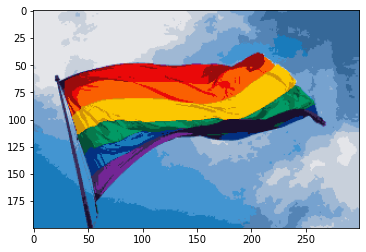

Orange True
Yellow True
Lime False
Green False
Mint Green False
Acquamarine False
Blue False
Indigo False
Violet False
Purple False
Pink True
Red True
Numero cluster hue: 4
Num colors: 10


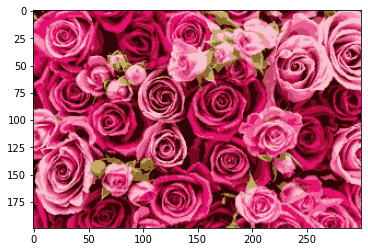

Orange True
Yellow False
Lime False
Green False
Mint Green False
Acquamarine False
Blue True
Indigo True
Violet True
Purple True
Pink True
Red True
Numero cluster hue: 7
Num colors: 18


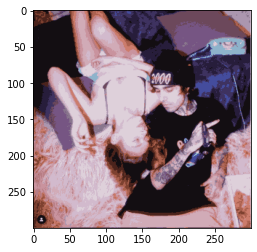

Orange True
Yellow False
Lime False
Green False
Mint Green False
Acquamarine False
Blue False
Indigo False
Violet False
Purple False
Pink False
Red False
Numero cluster hue: 1
Num colors: 3


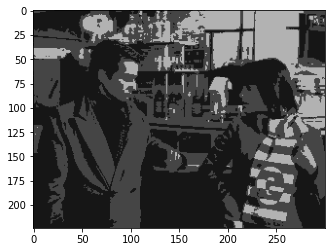

In [26]:
img_mykmeans= my_kmeans(img_rgb3)

plt.imshow(img_mykmeans)
plt.show()

img_mykmeans2= my_kmeans(img_rgb2)

plt.imshow(img_mykmeans2)
plt.show()

img_mykmeans3= my_kmeans(img_rgb1)

plt.imshow(img_mykmeans3)
plt.show()

img_mykmeans4= my_kmeans(img_rgb4)

plt.imshow(img_mykmeans4)
plt.show()


Come si nota l'algoritmo individua i colori presenti nella foto e di conseguenza il k approssimativamente più adatto al k-means.

##Estrazione della palette di colori

Implementazione di una funzione (**palette_extractor**) che estrae un set di colori da un'immagine secondo le politiche esposte in precedenza. Questa funzione verrà inserita nel modulo PaletteGen.py e servirà per il post-processing dell'output.

In [27]:
def palette_extractor(img):

  #Applicazione dell'algoritmo di clustering 
  img_out_rgb = my_kmeans(img)

  #Estraggo i colori unici dall'immagine
  img_flatten = img_out_rgb.reshape(img_out_rgb.shape[0]*img_out_rgb.shape[1], 3)

  color_unique = np.unique(img_flatten, axis=0)

  #Ottengo una palette di colori RGB in uscita
  return color_unique


#Esempio

print('PALETTE:', palette_extractor(img_rgb3))

Orange True
Yellow True
Lime False
Green False
Mint Green False
Acquamarine True
Blue True
Indigo True
Violet True
Purple True
Pink False
Red True
Numero cluster hue: 8
Num colors: 20
PALETTE: [[  5 130  83]
 [ 11  47 118]
 [ 23 122 186]
 [ 30  25  52]
 [ 54 104 152]
 [ 63 147 208]
 [ 83 131 180]
 [105 158 208]
 [109  36 143]
 [135 161 193]
 [135 174 215]
 [152  13  12]
 [161 190 220]
 [172 185 201]
 [192 203 218]
 [213 217 224]
 [231 232 234]
 [234   9   9]
 [245  99   2]
 [248 195   2]]
